In [1]:

import collections as c

%matplotlib inline
import numpy as np
import pandas as pd
import string
from numpy.random import normal,random,seed
from scipy.stats import norm
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV,cross_val_score,train_test_split
from sklearn.metrics import log_loss
import xgboost as xgb
from xgboost.sklearn import XGBClassifier, XGBRegressor
#import lightgbm as lgb

In [2]:
df = pd.read_csv('clean_data.csv')

df.head(5)

,DATE,WEEK_OF_YEAR,CAMPAIGN,CAMPAIGN_TYPE,KEYWORD,NETWORK,POSITION,Clicks,Impressions,Media_Cost,Page_Views,Time_On_Site_Total,Visits,Visitor_Bounce,CPC
0,5/21/2017 0:00,21,39,1,symptoms of asthma,1,2.08,3,51,5.40,2,13,2,1,1.8
1,5/21/2017 0:00,21,39,1,breathing with asthma,1,2.00,1,4,3.71,1,7,1,0,3.71
2,5/21/2017 0:00,21,46,1,asthma inhaler names,1,2.00,1,1,3.58,1,42,1,0,3.58
3,5/21/2017 0:00,21,40,1,breathing problems asthma,1,1.00,1,1,3.24,1,0,1,0,3.24
4,5/21/2017 0:00,21,48,1,asthma inhaler otc,1,1.70,1,3,3.76,1,4,1,0,3.76


In [3]:
##extract most common words to build features - granular

import numpy as np
#categories: asthma Symptom treatment brand chemicals payment age cause


# 1. symptom
df['symptom'] = np.select(
    condlist=[ # note you could use the case-insensitive search with `case=False`
        df['KEYWORD'].str.contains('symptoms', case=False),
        df['KEYWORD'].str.contains('signs', case=False),
        df['KEYWORD'].str.contains('coughing'),
        df['KEYWORD'].str.contains('breathing'),
        df['KEYWORD'].str.contains('inflammation')
    ],
    choicelist=[1, 2, 3, 4, 5], # dummy variables
    default=0 # you could set it to `np.nan` etc
)

# 2. asthma
df['asthma'] = np.select(
    condlist=[ # note you could use the case-insensitive search with `case=False`
        df['KEYWORD'].str.contains('asthma', case=False),
        df['KEYWORD'].str.contains('asma', case=False),
        df['KEYWORD'].str.contains('asthmatic'),
        df['KEYWORD'].str.contains('asthmas')
    ],
    choicelist=[1, 2, 3, 4], # dummy variables
    default=0 # you could set it to `np.nan` etc
)

# 3. treatment
df['treatment'] = np.select(
    condlist=[ # note you could use the case-insensitive search with `case=False`
        df['KEYWORD'].str.contains('inhaler|inhalers', case=False),
        df['KEYWORD'].str.contains('dosage|dosing|dose', case=False),
        df['KEYWORD'].str.contains('80|40|mcg|mg'),
        df['KEYWORD'].str.contains('treatment|treatments'),
        df['KEYWORD'].str.contains('side|effects'),
        df['KEYWORD'].str.contains('medications|medication|medicine|medicines', case=False),
        df['KEYWORD'].str.contains('action', case=False),
        df['KEYWORD'].str.contains('plan'),
        df['KEYWORD'].str.contains('inhalation|aerosol'),
        df['KEYWORD'].str.contains('over|otc', case=False),
        df['KEYWORD'].str.contains('relief'),
        df['KEYWORD'].str.contains('control|treat'),
        df['KEYWORD'].str.contains('nasal'),
        df['KEYWORD'].str.contains('use|used')
    ],
    choicelist=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], # dummy variables
    default=0 # you could set it to `np.nan` etc
)

# 4. brand
df['brand'] = np.select(
    condlist=[ # note you could use the case-insensitive search with `case=False`
        df['KEYWORD'].str.contains('product1', case=False),
        df['KEYWORD'].str.contains('competitor1', case=False),
        df['KEYWORD'].str.contains('competitor5'),
        df['KEYWORD'].str.contains('competitor7'),
        df['KEYWORD'].str.contains('competitor6'),
        df['KEYWORD'].str.contains('generic'),
        df['KEYWORD'].str.contains('competitor8'),
        df['KEYWORD'].str.contains('product1.com'),
        df['KEYWORD'].str.contains('brands')    
    ],
    choicelist=[1, 2, 3, 4, 5, 6, 7, 8, 9], # dummy variables
    default=0 # you could set it to `np.nan` etc
)
 
# 5. chemical
df['chemical'] = np.select(
    condlist=[ # note you could use the case-insensitive search with `case=False`
        df['KEYWORD'].str.contains('hfa', case=False),
        df['KEYWORD'].str.contains('names', case=False),
        df['KEYWORD'].str.contains('beclomethasone'),
        df['KEYWORD'].str.contains('budesonide'),
        df['KEYWORD'].str.contains('corticosteroid'),
        df['KEYWORD'].str.contains('q|var|quvar')  
    ],
    choicelist=[1, 2, 3, 4, 5, 6], # dummy variables
    default=0 # you could set it to `np.nan` etc
)

# 6. payment
df['payment'] = np.select(
    condlist=[ # note you could use the case-insensitive search with `case=False`
        df['KEYWORD'].str.contains('coupon|coupons', case=False),
        df['KEYWORD'].str.contains('copay', case=False),
        df['KEYWORD'].str.contains('patient|assistance'),
        df['KEYWORD'].str.contains('savings|discount'),
        df['KEYWORD'].str.contains('free'),
        df['KEYWORD'].str.contains('cost|price|prices')  
    ],
    choicelist=[1, 2, 3, 4, 5, 6], # dummy variables
    default=0 # you could set it to `np.nan` etc
)

# 6. Age
df['age'] = np.select(
    condlist=[ # note you could use the case-insensitive search with `case=False`
        df['KEYWORD'].str.contains('children|child|childhood|kids', case=False),
        df['KEYWORD'].str.contains('adults', case=False)
    ],
    choicelist=[1, 2], # dummy variables
    default=0 # you could set it to `np.nan` etc
)

# 6. cause
df['cause'] = np.select(
    condlist=[ # note you could use the case-insensitive search with `case=False`
        df['KEYWORD'].str.contains('causes|cause', case=False),
        df['KEYWORD'].str.contains('triggers', case=False)
    ],
    choicelist=[1, 2], # dummy variables
    default=0 # you could set it to `np.nan` etc
)




In [4]:
df.head()

,DATE,WEEK_OF_YEAR,CAMPAIGN,CAMPAIGN_TYPE,KEYWORD,NETWORK,POSITION,Clicks,Impressions,Media_Cost,...,Visitor_Bounce,CPC,symptom,asthma,treatment,brand,chemical,payment,age,cause
0,5/21/2017 0:00,21,39,1,symptoms of asthma,1,2.08,3,51,5.40,...,1,1.8,1,1,0,0,0,0,0,0
1,5/21/2017 0:00,21,39,1,breathing with asthma,1,2.00,1,4,3.71,...,0,3.71,4,1,0,0,0,0,0,0
2,5/21/2017 0:00,21,46,1,asthma inhaler names,1,2.00,1,1,3.58,...,0,3.58,0,1,1,0,2,0,0,0
3,5/21/2017 0:00,21,40,1,breathing problems asthma,1,1.00,1,1,3.24,...,0,3.24,4,1,0,0,0,0,0,0
4,5/21/2017 0:00,21,48,1,asthma inhaler otc,1,1.70,1,3,3.76,...,0,3.76,0,1,1,0,0,0,0,0


In [5]:
df['CTR'] = (df['Clicks']/df['Impressions'])
df['CTR'].head()

0    0.058824
1    0.250000
2    1.000000
3    1.000000
4    0.333333
Name: CTR, dtype: float64

In [6]:
#df2 = df.drop(labels=['DATE','WEEK_OF_YEAR','KEYWORD','Impressions','CPC','Page_Views', 'Clicks', 'Time_On_Site_Total','Visits', 'Visitor_Bounce'], axis=1) 
#df2.head()

In [7]:
#Identify mean of ctr
df_mean = df['CTR'].mean()
df_mean

#identify traits of top 10% - not completed
df3 = df2.sort_values('CTR', axis=0, ascending=False)
top10=df3.nlargest(7000,'CTR')
top10.describe()

NameError: name 'df2' is not defined

In [9]:
#X = df.drop(labels=['DATE','KEYWORD','Clicks','Impressions','CTR','CPC'], axis=1) 

X = df.drop(labels=['DATE','WEEK_OF_YEAR','KEYWORD','Impressions','CPC','Page_Views', 'Clicks', 'Time_On_Site_Total','Visits', 'Visitor_Bounce','CTR'], axis=1) 


In [118]:
X.head(5)

,CAMPAIGN,CAMPAIGN_TYPE,NETWORK,symptom,asthma,treatment,brand,chemical,payment,age,cause
0,39,1,1,1,1,0,0,0,0,0,0
1,39,1,1,4,1,0,0,0,0,0,0
2,46,1,1,0,1,1,0,2,0,0,0
3,40,1,1,4,1,0,0,0,0,0,0
4,48,1,1,0,1,1,0,0,0,0,0


In [10]:
y=df.loc[:,'CTR']

#for y, take log(CTR)
#y=df.loc[:,'Impressions']
y.head()
#X=.iloc[:,1:8]

0    0.058824
1    0.250000
2    1.000000
3    1.000000
4    0.333333
Name: CTR, dtype: float64

In [78]:
##Checking for 0s
df.loc[df['Clicks'] == 0]

,DATE,WEEK_OF_YEAR,CAMPAIGN,CAMPAIGN_TYPE,KEYWORD,NETWORK,POSITION,Clicks,Impressions,Media_Cost,...,CPC,symptom,asthma,treatment,brand,chemical,payment,age,cause,CTR
117,5/20/2017 0:00,20,49,1,asthma breathing treatment,0,3.06,0,73,0.0,...,#DIV/0!,4,1,4,0,0,0,0,0,0.0
156,5/20/2017 0:00,20,8,0,product1 inhalation,1,1.43,0,28,0.0,...,#DIV/0!,0,0,9,1,0,0,0,0,0.0
196,5/20/2017 0:00,20,8,0,product1 manufacturer coupon,1,1.00,0,7,0.0,...,#DIV/0!,0,0,0,1,0,1,0,0,0.0
300,5/20/2017 0:00,20,8,0,product1 manufacturer,1,1.00,0,1,0.0,...,#DIV/0!,0,0,0,1,0,0,0,0,0.0
391,5/19/2017 0:00,20,49,1,asthma breathing treatment,0,3.19,0,60,0.0,...,#DIV/0!,4,1,4,0,0,0,0,0,0.0
477,5/19/2017 0:00,20,41,1,cause asthma,0,3.38,0,16,0.0,...,#DIV/0!,0,1,14,0,0,0,0,1,0.0
627,5/18/2017 0:00,20,36,1,competitor9 aqua,1,3.00,0,2,0.0,...,#DIV/0!,0,0,0,0,6,0,0,0,0.0
666,5/18/2017 0:00,20,39,1,what is asthma symptoms,0,1.13,0,8,0.0,...,#DIV/0!,1,1,0,0,0,0,0,0,0.0
698,5/18/2017 0:00,20,37,1,competitor5 inhaler,0,6.37,0,19,0.0,...,#DIV/0!,0,0,1,3,0,0,0,0,0.0
796,5/17/2017 0:00,20,8,0,product1 inhaler coupon,1,1.00,0,8,0.0,...,#DIV/0!,0,0,1,1,0,1,0,0,0.0


# Random Forest

In [11]:
# Basic imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
# Set seed for reproducibility
SEED = 1
# Split dataset into 70% train and 30% test
X_train, X_test, y_train, y_test = \
train_test_split(X, y,
test_size=0.3,
random_state=SEED)

In [12]:
# Instantiate a random forests regressor 'rf' 400 estimators
rf = RandomForestRegressor(n_estimators=400,
min_samples_leaf=0.12,
random_state=SEED)
# Fit 'rf' to the training set
rf.fit(X_train, y_train)
# Predict the test set labels 'y_pred'
y_pred = rf.predict(X_test)
y_pred_train=rf.predict(X_train)
# Evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred)**(1/2)
rmse_train = MSE(y_train, y_pred_train)**(1/2)
# Print the test set RMSE
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))
print('Train set RMSE of rf: {:.2f}'.format(rmse_train))

Test set RMSE of rf: 0.29
Train set RMSE of rf: 0.29


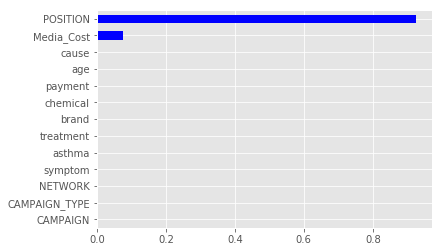

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
# Create a pd.Series of features importances
importances_rf = pd.Series(rf.feature_importances_,
index = X.columns)
# Sort importances_rf
sorted_importances_rf = importances_rf.sort_values()
# Make a horizontal bar plot
sorted_importances_rf.plot(kind='barh', color='blue')
plt.show()

XGBoost

In [220]:
def RMSE(x,y): 
    return np.mean((x - y)**2)**0.5
rfSearch200 = RandomForestRegressor(n_estimators=200,random_state=0,
                                    oob_score=True,n_jobs=-1,max_features=6)
rfSearch200.fit(X, y)
print('train RMSE =',RMSE(y,rfSearch200.predict(X)))

train RMSE = 0.1352047043410771


In [221]:
param = {'objective': 'reg:squarederror'}

In [222]:
dtrain = xgb.DMatrix(X, label=y)

C:\Users\manya\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\manya\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [223]:
cvSearch = xgb.cv(param, dtrain, nfold = 3,num_boost_round=75,verbose_eval=10)
cvSearch.tail(20)

[0]	train-rmse:0.327547+0.000172028	test-rmse:0.327863+0.000326249
[10]	train-rmse:0.231656+0.000567622	test-rmse:0.235642+0.000424434
[20]	train-rmse:0.226217+0.000773803	test-rmse:0.232139+0.000568416
[30]	train-rmse:0.222546+0.000437972	test-rmse:0.230772+0.000357917
[40]	train-rmse:0.219767+0.000510518	test-rmse:0.230142+0.000360515
[50]	train-rmse:0.217825+0.000738448	test-rmse:0.229982+0.000338589
[60]	train-rmse:0.215803+0.000696403	test-rmse:0.229821+0.000330749
[70]	train-rmse:0.21407+0.000480346	test-rmse:0.229861+0.000301982
[74]	train-rmse:0.213524+0.000483692	test-rmse:0.229886+0.000312402


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
55,0.216807,0.000608,0.229865,0.000400
56,0.216670,0.000665,0.229837,0.000399
57,0.216476,0.000660,0.229847,0.000392
58,0.216309,0.000698,0.229825,0.000358
59,0.216040,0.000740,0.229818,0.000357
60,0.215803,0.000696,0.229821,0.000331
61,0.215662,0.000637,0.229837,0.000346
62,0.215509,0.000611,0.229825,0.000338
63,0.215364,0.000583,0.229776,0.000361
64,0.215168,0.000531,0.229757,0.000340


best number of rounds = 64
rmse = 0.2297566666666667


C:\Users\manya\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


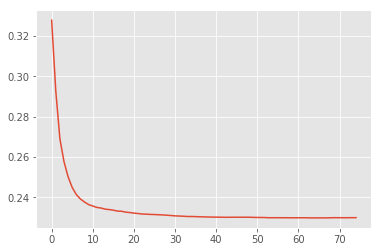

In [224]:
eps = 1e-6
bestNR = np.argmax(cvSearch['test-rmse-mean']<eps+min(cvSearch['test-rmse-mean']))
bestRMSE = cvSearch.loc[bestNR,'test-rmse-mean']
plt.plot(cvSearch['test-rmse-mean'])
print('best number of rounds =',bestNR)
print('rmse =',bestRMSE) #using bestNR

In [225]:
modelSearch = xgb.train(param, dtrain,num_boost_round=bestNR)
print(RMSE(y,modelSearch.predict(xgb.DMatrix(X))))

0.2183176501496354


In [226]:
regSearch = XGBRegressor(objective='reg:squarederror',n_estimators=bestNR)
regSearch.fit(X,y)
print(RMSE(y,regSearch.predict(X)))

0.24597571526088507


In [227]:
regSearch = XGBRegressor(objective='reg:squarederror',n_estimators=bestNR, max_depth=6,
                         learning_rate=0.3)
regSearch.fit(X,y)
print(RMSE(y,regSearch.predict(X)))

0.2183176501496354


In [228]:
# xgboost task parameters
folds = 3

# Parameters grid to search
param_test1 = {
    'learning_rate':[.3,.15,.05],
    'max_depth':[4,5,6],
    'n_estimators':np.append(range(30,90,10),bestNR)
}

In [229]:
grid = GridSearchCV(estimator = XGBRegressor(objective= 'reg:squarederror',
                    nthread=1, seed=0), scoring = 'neg_mean_squared_error',
                    param_grid = param_test1, n_jobs=-1,cv=folds,iid=False)
grid.fit(X, y)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=1, objective='reg:squarederror', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'learning_rate': [0.3, 0.15, 0.05], 'max_depth': [4, 5, 6], 'n_estimators': array([30, 40, 50, 60, 70, 80, 64])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [230]:
grid.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_learning_rate', 'param_max_depth', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])

In [231]:
# summarize results
for mean,param in zip(grid.cv_results_['mean_test_score'],grid.cv_results_['params']):
    print("%f with: " % -mean,param)

0.057467 with:  {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 30}
0.057022 with:  {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 40}
0.056879 with:  {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 50}
0.056693 with:  {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 60}
0.056519 with:  {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 70}
0.056394 with:  {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 80}
0.056650 with:  {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 64}
0.056915 with:  {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 30}
0.056831 with:  {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 40}
0.057018 with:  {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 50}
0.056915 with:  {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 60}
0.057051 with:  {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 70}
0.057162 with:  {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 80}
0.056894 with:  {'learnin

In [232]:
print('MSE before tuning: %f' % bestRMSE**2)
print("Best MSE after tuning: %f using %s" % (-grid.best_score_,grid.best_params_))

MSE before tuning: 0.052788
Best MSE after tuning: 0.056152 using {'learning_rate': 0.15, 'max_depth': 6, 'n_estimators': 70}


In [190]:
##R^2 from XGBoost?

In [89]:
##using columns b-e, j to predict i and p
##change positions and impressions back to missing_values
##try linear
#campaign, campaign type, keyword, network, media_cost, and positions to predict click, impression, CTR/Flag

# Date-based models (can ignore the next few cells)

In [5]:
#dates = df.DATE.unique()
#dates

In [82]:
#select dates
#jan416
#jan416 = df["DATE"] == "1/4/2016 0:00"
#filtered_dates = df.loc[jan416]

#may1717 = df["DATE"] == "5/17/2017 0:00"
#filtered_dates = df.loc[may1717]

#print(filtered_dates)

In [83]:
#jan416df = pd.DataFrame(filtered_dates)
#may1717df = pd.DataFrame(filtered_dates)


In [3]:
#jan416df.ndim
#jan416df.size
#jan416df.shape
#may1717df.shape

In [6]:
#campaign, campaign type, keyword, network, media_cost, and positions to predict click, impression, CTR/Flag

#y = jan416df.loc[:,'CTR']
#X = jan416df.drop(labels=['DATE','WEEK_OF_YEAR','KEYWORD','Impressions','CPC','Page_Views', 'Clicks', 'Time_On_Site_Total','Visits', 'Visitor_Bounce'], axis=1)

#y = may1717df.loc[:,'CTR']
#X = may1717df.drop(labels=['DATE','WEEK_OF_YEAR','KEYWORD','Impressions','CPC','Page_Views', 'Clicks', 'Time_On_Site_Total','Visits', 'Visitor_Bounce','CTR'], axis=1) 

Comparing results

In [141]:
##values for y = clicks
print('y=clicks')
print('XGBoost')
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))
print('Train set RMSE of rf: {:.2f}'.format(rmse_train))
print('train RMSE =',RMSE(y,rfSearch200.predict(X)))

print('ADABoost')
print('Test set RMSE of rf: {:.2f}'.format(ada_rmse_test))
print('Train set RMSE of rf: {:.2f}'.format(ada_rmse_train))
print('train RMSE =',RMSE(y,adaSearch200.predict(X)))

y=clicks
XGBoost
Test set RMSE of rf: 6.43
Train set RMSE of rf: 16.92
train RMSE = 4.2467823819922765
ADABoost
Test set RMSE of rf: 3.80
Train set RMSE of rf: 2.29
train RMSE = 3.2994110800608234


In [155]:
##values for y = impressions
print('y=impressions')
print('XGBoost')
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))
print('Train set RMSE of rf: {:.2f}'.format(rmse_train))
print('train RMSE =',RMSE(y,rfSearch200.predict(X)))

print('ADABoost')
print('Test set RMSE of rf: {:.2f}'.format(ada_rmse_test))
print('Train set RMSE of rf: {:.2f}'.format(ada_rmse_train))
print('train RMSE =',RMSE(y,adaSearch200.predict(X)))

y=impressions
XGBoost
Test set RMSE of rf: 135.74
Train set RMSE of rf: 232.26
train RMSE = 66.68830060863368
ADABoost
Test set RMSE of rf: 232.75
Train set RMSE of rf: 66.88
train RMSE = 52.30926533522398


In [177]:
##values for y = ctr
print('y=CTR')
print('XGBoost')
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))
print('Train set RMSE of rf: {:.2f}'.format(rmse_train))
print('train RMSE =',RMSE(y,rfSearch200.predict(X)))

print('ADABoost')
print('Test set RMSE of rf: {:.2f}'.format(ada_rmse_test))
print('Train set RMSE of rf: {:.2f}'.format(ada_rmse_train))
print('train RMSE =',RMSE(y,adaSearch200.predict(X)))

y=CTR
XGBoost
Test set RMSE of rf: 0.30
Train set RMSE of rf: 0.24
train RMSE = 0.10029652661875361
ADABoost
Test set RMSE of rf: 0.30
Train set RMSE of rf: 0.23
train RMSE = 0.2643011975134384


In [195]:
##values for y = CTR,w Keywords
print('y=CTR, including Keyword extractions')
print('XGBoost')
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))
print('Train set RMSE of rf: {:.2f}'.format(rmse_train))
print('train RMSE =',RMSE(y,rfSearch200.predict(X)))

print('ADABoost')
print('Test set RMSE of rf: {:.2f}'.format(ada_rmse_test))
print('Train set RMSE of rf: {:.2f}'.format(ada_rmse_train))
print('train RMSE =',RMSE(y,adaSearch200.predict(X)))

y=CTR, including Keyword extractions
XGBoost
Test set RMSE of rf: 0.08
Train set RMSE of rf: 0.09
train RMSE = 0.004341877226802633
ADABoost
Test set RMSE of rf: 0.03
Train set RMSE of rf: 0.03
train RMSE = 0.03526830172729438


In [56]:
##values for y = CTR,w Keywords
print('y=CTR, including Keyword extractions')
print('XGBoost')
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))
print('Train set RMSE of rf: {:.2f}'.format(rmse_train))
print('train RMSE =',RMSE(y,rfSearch200.predict(X)))

print('ADABoost')
print('Test set RMSE of rf: {:.2f}'.format(ada_rmse_test))
print('Train set RMSE of rf: {:.2f}'.format(ada_rmse_train))
print('train RMSE =',RMSE(y,adaSearch200.predict(X)))

y=CTR, including Keyword extractions
XGBoost
Test set RMSE of rf: 0.24
Train set RMSE of rf: 0.24
train RMSE = 0.09270842913216387
ADABoost
Test set RMSE of rf: 0.29
Train set RMSE of rf: 0.29
train RMSE = 0.327616666202614


In [112]:
y = jan416df.loc[:,'CTR']
X = jan416df.drop(labels=['DATE','WEEK_OF_YEAR','KEYWORD','Impressions','CPC','Page_Views', 'Clicks', 'Time_On_Site_Total','Visits', 'Visitor_Bounce','CTR'], axis=1) 

In [113]:
#y.head()
#transform response variable by log
#most important predictor and word?

X.head()

,CAMPAIGN,CAMPAIGN_TYPE,NETWORK,POSITION,Media_Cost,symptom,asthma,treatment,brand,chemical,payment,age,cause
77914,8,0,0,1.0,2.20,0,0,3,1,0,0,0,0
77915,8,0,1,1.0,1.57,0,0,0,1,0,1,0,0
77916,37,1,1,2.0,1.90,0,0,1,3,0,0,0,0
77917,8,0,1,1.0,4.53,0,0,0,1,0,0,0,0
77918,8,0,0,1.0,1.00,0,0,0,0,6,0,0,0


In [87]:
X.shape

(266, 13)

In [191]:
SEED = 1
# Split dataset into 70% train and 30% test
X_train, X_test, y_train, y_test = \
train_test_split(X, y,
test_size=0.3,
random_state=SEED)

In [233]:
rf = RandomForestRegressor(n_estimators=400,
min_samples_leaf=0.12,
random_state=SEED)
# Fit 'rf' to the training set
rf.fit(X_train, y_train)
# Predict the test set labels 'y_pred'
y_pred = rf.predict(X_test)
y_pred_train=rf.predict(X_train)

# Evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred)**(1/2)
rmse_train = MSE(y_train, y_pred_train)**(1/2)
#Computer R^2 between y_pred and y_pred_train
R2_train = np.corrcoef(y_train, y_pred_train)**2
R2_test = np.corrcoef(y_test, y_pred)**2

print(R2_train)
print(R2_test)

# Print the test set RMSE
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))
print('Train set RMSE of rf: {:.2f}'.format(rmse_train))

[[1.        0.0095084]
 [0.0095084 1.       ]]
[[1.        0.0086219]
 [0.0086219 1.       ]]
Test set RMSE of rf: 420.36
Train set RMSE of rf: 396.42


In [194]:
def RMSE(x,y): 
    return np.mean((x - y)**2)**0.5
rfSearch200 = RandomForestRegressor(n_estimators=200,random_state=0,
                                    oob_score=True,n_jobs=-1)#,max_features=6)
rfSearch200.fit(X, y)
print('train RMSE =',RMSE(y,rfSearch200.predict(X)))

train RMSE = 322.4657379328574


ADABoost

In [195]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
# Set seed for reproducibility
SEED = 1
# Split data into 70% train and 30% test
X_train, X_test, y_train, y_test = \
train_test_split(X, y,
test_size=0.3,
random_state=SEED)

In [196]:
# Import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

# Import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor

# Instantiate dt
dt = DecisionTreeRegressor(max_depth=2, random_state=1)

# Instantiate ada
ada = AdaBoostRegressor(base_estimator=dt, n_estimators=180, random_state=1)

In [197]:
# Fit ada to the training set
ada.fit(X_train, y_train)

# Compute the probabilities of obtaining the positive class
ada_y_pred = ada.predict(X_test)

In [198]:
ada_y_pred_train=ada.predict(X_train)
# Evaluate the test set RMSE
ada_rmse_test = MSE(y_test, ada_y_pred)**(1/2)
ada_rmse_train = MSE(y_train, ada_y_pred_train)**(1/2)
# Print the test set RMSE
print('Test set RMSE of rf: {:.2f}'.format(ada_rmse_test))
print('Train set RMSE of rf: {:.2f}'.format(ada_rmse_train))

Test set RMSE of rf: 454.23
Train set RMSE of rf: 446.34


In [199]:
def RMSE(x,y): 
    return np.mean((x - y)**2)**0.5
adaSearch200 = AdaBoostRegressor(base_estimator=dt, n_estimators=180, random_state=1)
adaSearch200.fit(X, y)
print('train RMSE =',RMSE(y,adaSearch200.predict(X)))

train RMSE = 415.36452782856094


More XGBoost attempts

In [200]:
# train-test split evaluation of xgboost model
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# load data
#dataset = loadtxt('pima-indians-diabetes.csv', delimiter=",")
# split data into X and y
#X = dataset[:,0:8]
#Y = dataset[:,8]
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)
# fit model no training data
model = XGBRegressor()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
#accuracy = accuracy_score(y_test, predictions)
#print("Accuracy: %.2f%%" % (accuracy * 100.0))

C:\Users\manya\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:42:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [201]:
# Predict the test set labels 'y_pred'
#y_pred = rf.predict(X_test)
y_pred_train=model.predict(X_train)

# Evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred)**(1/2)
rmse_train = MSE(y_train, y_pred_train)**(1/2)
#Computer R^2 between y_pred and y_pred_train
R2_train = np.corrcoef(y_train, y_pred_train)**2
R2_test = np.corrcoef(y_test, y_pred)**2

print(R2_train)
print(R2_test)

# Print the test set RMSE
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))
print('Train set RMSE of rf: {:.2f}'.format(rmse_train))

[[1.         0.20435664]
 [0.20435664 1.        ]]
[[1.         0.25891023]
 [0.25891023 1.        ]]
Test set RMSE of rf: 350.06
Train set RMSE of rf: 361.62


[[1.         0.94523873]
 [0.94523873 1.        ]]
[[1.         0.38299187]
 [0.38299187 1.        ]]
Test set RMSE of rf: 0.25
Train set RMSE of rf: 0.09


In [202]:
# k-fold cross validation evaluation of xgboost model
from numpy import loadtxt
import xgboost
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# load data
#dataset = loadtxt('pima-indians-diabetes.csv', delimiter=",")
# split data into X and y
#X = dataset[:,0:8]
#Y = dataset[:,8]
# CV model
model = xgboost.XGBRegressor()
kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(model, X, y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

C:\Users\manya\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:42:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\manya\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:42:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\manya\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:43:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\manya\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:43:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\manya\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:43:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\manya\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:43:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\manya\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:43:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\manya\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:43:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\manya\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:43:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\manya\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:43:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Accuracy: 5.59% (19.04%)


In [203]:
#XGB rmse
rf = RandomForestRegressor(n_estimators=400,
min_samples_leaf=0.12,
random_state=SEED)
# Fit 'rf' to the training set
rf.fit(X_train, y_train)
# Predict the test set labels 'y_pred'
y_pred = rf.predict(X_test)
y_pred_train=rf.predict(X_train)

# Evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred)**(1/2)
rmse_train = MSE(y_train, y_pred_train)**(1/2)
#Computer R^2 between y_pred and y_pred_train
R2_train = np.corrcoef(y_train, y_pred_train)**2
R2_test = np.corrcoef(y_test, y_pred)**2

print(R2_train)
print(R2_test)

# Print the test set RMSE
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))
print('Train set RMSE of rf: {:.2f}'.format(rmse_train))

[[1.         0.00930614]
 [0.00930614 1.        ]]
[[1.         0.00962729]
 [0.00962729 1.        ]]
Test set RMSE of rf: 395.94
Train set RMSE of rf: 400.32


Another XGBoost Method

In [204]:
#https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.1, random_state=42)

In [205]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.1, random_state=42)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

C:\Users\manya\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [206]:
import numpy as np
# "Learn" the mean from the training data
mean_train = np.mean(y_train)
# Get predictions on the test set
baseline_predictions = np.ones(y_test.shape) * mean_train
# Compute MAE
mae_baseline = mean_absolute_error(y_test, baseline_predictions)
print("Baseline MAE is {:.2f}".format(mae_baseline))


Baseline MAE is 125.41


In [134]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
}

In [135]:
params['eval_metric'] = "mae"

In [136]:
num_boost_round = 999

In [138]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

print("Best MAE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))


[11:41:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-mae:0.308903
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:0.274848
[2]	Test-mae:0.25271
[3]	Test-mae:0.237367
[4]	Test-mae:0.226884
[5]	Test-mae:0.220226
[6]	Test-mae:0.215454
[7]	Test-mae:0.212214
[8]	Test-mae:0.209745
[9]	Test-mae:0.207278
[10]	Test-mae:0.206046
[11]	Test-mae:0.205124
[12]	Test-mae:0.2043
[13]	Test-mae:0.20369
[14]	Test-mae:0.203128
[15]	Test-mae:0.20277
[16]	Test-mae:0.202468
[17]	Test-mae:0.20185
[18]	Test-mae:0.201635
[19]	Test-mae:0.201518
[20]	Test-mae:0.201097
[21]	Test-mae:0.200977
[22]	Test-mae:0.200917
[23]	Test-mae:0.2007
[24]	Test-mae:0.20031
[25]	Test-mae:0.199893
[26]	Test-mae:0.199443
[27]	Test-mae:0.199368
[28]	Test-mae:0.199278
[29]	Test-mae:0.199218
[30]	Test-mae:0.199175
[31]	Test-mae:0.198938
[32]	Test-mae:0.198821
[33]	Test-mae:0.198585
[34]	Test-mae:0.1

In [139]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'mae'},
    early_stopping_rounds=10
)
cv_results

[11:41:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:41:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:41:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:41:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:41:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,0.305540,0.000266,0.305658,0.000905
1,0.272107,0.000381,0.272341,0.000864
2,0.250421,0.000472,0.250786,0.000894
3,0.235340,0.000615,0.235759,0.000984
4,0.225413,0.000574,0.225926,0.001076
5,0.218527,0.000704,0.219111,0.000961
6,0.213673,0.000611,0.214371,0.001084
7,0.210113,0.000601,0.210841,0.001029
8,0.207561,0.000504,0.208352,0.001180
9,0.205623,0.000539,0.206469,0.001149


In [140]:
cv_results['test-mae-mean'].min()

0.1943806

In [141]:
# You can try wider intervals with a larger step between
# each value and then narrow it down. Here after several
# iteration I found that the optimal value was in the
# following ranges.
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

In [142]:
# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=9, min_child_weight=5
[11:43:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:43:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:43:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:43:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:43:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\manya\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


	MAE 0.1943606 for 199 rounds
CV with max_depth=9, min_child_weight=6
[11:45:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:45:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:45:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:45:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:45:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 0.194387 for 218 rounds
CV with max_depth=9, min_child_weight=7
[11:47:23] WARNING: C:/Jenkins/workspace/

In [143]:
params['max_depth'] = 10
params['min_child_weight'] = 5

In [144]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [145]:
min_mae = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with subsample=1.0, colsample=1.0
[12:01:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:01:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:01:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:01:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:01:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\manya\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


	MAE 0.19428360000000003 for 236 rounds
CV with subsample=1.0, colsample=0.9
[12:03:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:03:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:03:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:03:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:03:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 0.19431199999999998 for 236 rounds
CV with subsample=1.0, colsample=0.8
[12:05:11] WARNING: C:/Jen

[12:14:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:14:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:14:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:14:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 0.1945538 for 76 rounds
CV with subsample=0.8, colsample=0.7
[12:15:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:15:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linea

In [161]:
params['subsample'] = 1
params['colsample_bytree'] = 1

In [160]:
%time
# This can take some time…
min_mae = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    %time cv_results = xgb.cv(params, dtrain, num_boost_round=num_boost_round, seed=42, nfold=5, metrics=['mae'], early_stopping_rounds=10)
    # Update best score
mean_mae = cv_results['test-mae-mean'].min()
boost_rounds = cv_results['test-mae-mean'].argmin()
print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
if mean_mae < min_mae:
    min_mae = mean_mae
    best_params = eta
print("Best params: {}, MAE: {}".format(best_params, min_mae))

Wall time: 0 ns
CV with eta=0.3
[12:28:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:28:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:28:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:28:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:28:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Wall time: 2min 6s
CV with eta=0.2
[12:30:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:line

C:\Users\manya\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  del sys.path[0]


In [164]:
#final parameters dict
params 
{'colsample_bytree': 1.0,
 'eta': 0.01,
 'eval_metric': 'mae',
 'max_depth': 10,
 'min_child_weight': 5,
 'objective': 'reg:squarederror',
 'subsample': 1.0}

{'colsample_bytree': 1.0,
 'eta': 0.01,
 'eval_metric': 'mae',
 'max_depth': 10,
 'min_child_weight': 5,
 'objective': 'reg:squarederror',
 'subsample': 1.0}

In [165]:
#train the model
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[14:46:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-mae:0.357788
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:0.356929
[2]	Test-mae:0.356076
[3]	Test-mae:0.355226
[4]	Test-mae:0.354381
[5]	Test-mae:0.35354
[6]	Test-mae:0.352703
[7]	Test-mae:0.351869
[8]	Test-mae:0.351039
[9]	Test-mae:0.350215
[10]	Test-mae:0.349392
[11]	Test-mae:0.348575
[12]	Test-mae:0.347765
[13]	Test-mae:0.346955
[14]	Test-mae:0.34615
[15]	Test-mae:0.345348
[16]	Test-mae:0.344553
[17]	Test-mae:0.343758
[18]	Test-mae:0.34297
[19]	Test-mae:0.342184
[20]	Test-mae:0.341402
[21]	Test-mae:0.340625
[22]	Test-mae:0.339851
[23]	Test-mae:0.339082
[24]	Test-mae:0.338317
[25]	Test-mae:0.337556
[26]	Test-mae:0.336797
[27]	Test-mae:0.336043
[28]	Test-mae:0.335293
[29]	Test-mae:0.334546
[30]	Test-mae:0.333802
[31]	Test-mae:0.333062
[32]	Test-mae:0.332326
[33]	Test-mae:0.331594
[34]	Test-m

[339]	Test-mae:0.224169
[340]	Test-mae:0.22404
[341]	Test-mae:0.223903
[342]	Test-mae:0.223774
[343]	Test-mae:0.223641
[344]	Test-mae:0.223512
[345]	Test-mae:0.223381
[346]	Test-mae:0.22325
[347]	Test-mae:0.223123
[348]	Test-mae:0.222994
[349]	Test-mae:0.222868
[350]	Test-mae:0.222743
[351]	Test-mae:0.222617
[352]	Test-mae:0.222493
[353]	Test-mae:0.22237
[354]	Test-mae:0.222245
[355]	Test-mae:0.222124
[356]	Test-mae:0.222005
[357]	Test-mae:0.221882
[358]	Test-mae:0.221762
[359]	Test-mae:0.221645
[360]	Test-mae:0.221525
[361]	Test-mae:0.221405
[362]	Test-mae:0.221289
[363]	Test-mae:0.221172
[364]	Test-mae:0.221059
[365]	Test-mae:0.220942
[366]	Test-mae:0.220831
[367]	Test-mae:0.220715
[368]	Test-mae:0.220603
[369]	Test-mae:0.220488
[370]	Test-mae:0.220378
[371]	Test-mae:0.220269
[372]	Test-mae:0.220157
[373]	Test-mae:0.220048
[374]	Test-mae:0.219941
[375]	Test-mae:0.219831
[376]	Test-mae:0.219725
[377]	Test-mae:0.21962
[378]	Test-mae:0.219512
[379]	Test-mae:0.219404
[380]	Test-mae:0.219

[682]	Test-mae:0.202835
[683]	Test-mae:0.202807
[684]	Test-mae:0.202781
[685]	Test-mae:0.202753
[686]	Test-mae:0.202725
[687]	Test-mae:0.202698
[688]	Test-mae:0.202671
[689]	Test-mae:0.202645
[690]	Test-mae:0.202619
[691]	Test-mae:0.202595
[692]	Test-mae:0.202569
[693]	Test-mae:0.202545
[694]	Test-mae:0.202519
[695]	Test-mae:0.202496
[696]	Test-mae:0.202473
[697]	Test-mae:0.202447
[698]	Test-mae:0.202424
[699]	Test-mae:0.2024
[700]	Test-mae:0.20238
[701]	Test-mae:0.202355
[702]	Test-mae:0.202336
[703]	Test-mae:0.202316
[704]	Test-mae:0.202292
[705]	Test-mae:0.202274
[706]	Test-mae:0.202255
[707]	Test-mae:0.202233
[708]	Test-mae:0.202211
[709]	Test-mae:0.202192
[710]	Test-mae:0.202169
[711]	Test-mae:0.202151
[712]	Test-mae:0.202133
[713]	Test-mae:0.202112
[714]	Test-mae:0.202094
[715]	Test-mae:0.202071
[716]	Test-mae:0.202051
[717]	Test-mae:0.202033
[718]	Test-mae:0.202016
[719]	Test-mae:0.202
[720]	Test-mae:0.201977
[721]	Test-mae:0.20196
[722]	Test-mae:0.201943
[723]	Test-mae:0.201922

In [166]:
print("Best MAE: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

Best MAE: 0.20 in 999 rounds


In [167]:
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

[15:03:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-mae:0.357788
[1]	Test-mae:0.356929
[2]	Test-mae:0.356076
[3]	Test-mae:0.355226
[4]	Test-mae:0.354381
[5]	Test-mae:0.35354
[6]	Test-mae:0.352703
[7]	Test-mae:0.351869
[8]	Test-mae:0.351039
[9]	Test-mae:0.350215
[10]	Test-mae:0.349392
[11]	Test-mae:0.348575
[12]	Test-mae:0.347765
[13]	Test-mae:0.346955
[14]	Test-mae:0.34615
[15]	Test-mae:0.345348
[16]	Test-mae:0.344553
[17]	Test-mae:0.343758
[18]	Test-mae:0.34297
[19]	Test-mae:0.342184
[20]	Test-mae:0.341402
[21]	Test-mae:0.340625
[22]	Test-mae:0.339851
[23]	Test-mae:0.339082
[24]	Test-mae:0.338317
[25]	Test-mae:0.337556
[26]	Test-mae:0.336797
[27]	Test-mae:0.336043
[28]	Test-mae:0.335293
[29]	Test-mae:0.334546
[30]	Test-mae:0.333802
[31]	Test-mae:0.333062
[32]	Test-mae:0.332326
[33]	Test-mae:0.331594
[34]	Test-mae:0.330867
[35]	Test-mae:0.330142
[36]	Test-mae:0.32942

[341]	Test-mae:0.223903
[342]	Test-mae:0.223774
[343]	Test-mae:0.223641
[344]	Test-mae:0.223512
[345]	Test-mae:0.223381
[346]	Test-mae:0.22325
[347]	Test-mae:0.223123
[348]	Test-mae:0.222994
[349]	Test-mae:0.222868
[350]	Test-mae:0.222743
[351]	Test-mae:0.222617
[352]	Test-mae:0.222493
[353]	Test-mae:0.22237
[354]	Test-mae:0.222245
[355]	Test-mae:0.222124
[356]	Test-mae:0.222005
[357]	Test-mae:0.221882
[358]	Test-mae:0.221762
[359]	Test-mae:0.221645
[360]	Test-mae:0.221525
[361]	Test-mae:0.221405
[362]	Test-mae:0.221289
[363]	Test-mae:0.221172
[364]	Test-mae:0.221059
[365]	Test-mae:0.220942
[366]	Test-mae:0.220831
[367]	Test-mae:0.220715
[368]	Test-mae:0.220603
[369]	Test-mae:0.220488
[370]	Test-mae:0.220378
[371]	Test-mae:0.220269
[372]	Test-mae:0.220157
[373]	Test-mae:0.220048
[374]	Test-mae:0.219941
[375]	Test-mae:0.219831
[376]	Test-mae:0.219725
[377]	Test-mae:0.21962
[378]	Test-mae:0.219512
[379]	Test-mae:0.219404
[380]	Test-mae:0.219302
[381]	Test-mae:0.2192
[382]	Test-mae:0.2190

[684]	Test-mae:0.202781
[685]	Test-mae:0.202753
[686]	Test-mae:0.202725
[687]	Test-mae:0.202698
[688]	Test-mae:0.202671
[689]	Test-mae:0.202645
[690]	Test-mae:0.202619
[691]	Test-mae:0.202595
[692]	Test-mae:0.202569
[693]	Test-mae:0.202545
[694]	Test-mae:0.202519
[695]	Test-mae:0.202496
[696]	Test-mae:0.202473
[697]	Test-mae:0.202447
[698]	Test-mae:0.202424
[699]	Test-mae:0.2024
[700]	Test-mae:0.20238
[701]	Test-mae:0.202355
[702]	Test-mae:0.202336
[703]	Test-mae:0.202316
[704]	Test-mae:0.202292
[705]	Test-mae:0.202274
[706]	Test-mae:0.202255
[707]	Test-mae:0.202233
[708]	Test-mae:0.202211
[709]	Test-mae:0.202192
[710]	Test-mae:0.202169
[711]	Test-mae:0.202151
[712]	Test-mae:0.202133
[713]	Test-mae:0.202112
[714]	Test-mae:0.202094
[715]	Test-mae:0.202071
[716]	Test-mae:0.202051
[717]	Test-mae:0.202033
[718]	Test-mae:0.202016
[719]	Test-mae:0.202
[720]	Test-mae:0.201977
[721]	Test-mae:0.20196
[722]	Test-mae:0.201943
[723]	Test-mae:0.201922
[724]	Test-mae:0.201902
[725]	Test-mae:0.201886

In [168]:
mean_absolute_error(best_model.predict(dtest), y_test)

0.198676450573943

In [169]:
best_model.save_model("my_model.model")

In [170]:
loaded_model = xgb.Booster()
loaded_model.load_model("my_model.model")
# And use it for predictions.
loaded_model.predict(dtest)

[15:32:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


array([0.46673247, 0.2326023 , 0.20840654, ..., 0.20840654, 0.10195741,
       0.55320233], dtype=float32)